In [2]:
%load_ext autoreload
%autoreload 2

# Verify conditional circuit generation

We have previously trained a neural network known as a conditional variational autoencoder on genetic circuits. The conditioning variable was made to be one of the characteristics of the genetic circuit's dynamics, for example the sensitivity of the circuit to a signal. While the distributions for each class of conditional variables differ in the AI-generated circuits, the verification of their ground-truth label is still necessary to assess the validity of the conditionality.

## Imports

In [3]:
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.setup import prepare_config, expand_config, expand_model_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.misc.numerical import symmetrical_matrix_length
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_unique
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import simulate_steady_states

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import diffrax as dfx

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[cuda(id=0), cuda(id=1)]

In [4]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify
from evoscaper.utils.math import arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import vis_sampled_histplot


## Load data

In [5]:
# # fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# # fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# # fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# # data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
# # data = pd.read_csv(fn_test_data)
# data = pd.read_csv(fn)
# len(data)

## Load model

### Hyperparameters

In [6]:
# # Stats
# SEED = 1
# PRNG = jax.random.PRNGKey(SEED)

# # Architecture
# USE_SIGMOID_DECODER = False
# HIDDEN_SIZE = 32
# ENC_LS = 64
# DEC_LS = 64
# NUM_ENC_LAYERS = 2
# NUM_DEC_LAYERS = 2
# enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
# dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 
# ENC_INIT = 'HeNormal'
# DEC_INIT = 'HeNormal'
# ACTIVATION = 'leaky_relu'

# # Dataset 
# OBJECTIVE_COL = 'Log sensitivity'  # 'adaptability'  # sensitivity_wrt_species-6
# # OBJECTIVE_COL = 'sensitivity_wrt_species-6'
# include_diffs = False
# X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
# OUTPUT_SPECIES = ['RNA_2']

# # Dataset training
# BATCH_SIZE = 128
# FILT_X_NANS = True
# FILT_Y_NANS = True
# FILT_SENSITIVITY_NANS = True
# FILT_PRECISION_NANS = True
# FILT_N_SAME_X_MAX = 1
# FILT_N_SAME_X_MAX_BINS = 50  # decrease to 10
# PREP_X_STANDARDISE = False
# PREP_Y_STANDARDISE = False
# PREP_X_MINMAX = True
# PREP_Y_MINMAX = True
# PREP_X_ROBUST_SCALING = True
# PREP_Y_ROBUST_SCALING = True
# PREP_X_LOGSCALE = False
# PREP_Y_LOGSCALE = False
# PREP_X_CATEGORICAL = False
# PREP_Y_CATEGORICAL = True
# PREP_X_CATEGORICAL_ONEHOT = False
# PREP_Y_CATEGORICAL_ONEHOT = True
# PREP_X_CATEGORICAL_NBINS = 10
# PREP_Y_CATEGORICAL_NBINS = 10
# PREP_X_CATEGORICAL_METHOD = 'quantile'
# PREP_Y_CATEGORICAL_METHOD = 'quantile'
# PREP_X_NEG = True
# PREP_Y_NEG = False
# TOTAL_DS_MAX = 3e6
# N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)

# # Training
# EPOCHS = 3000
# LEARNING_RATE = 1e-2
# LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
# TRAIN_SPLIT = 0.8
# USE_DROPOUT = False
# USE_L2_REG = False
# USE_KL_DIV = True
# USE_WARMUP = True
# WARMUP_EPOCHS = 20
# L2_REG_ALPHA = 5e-2
# PRINT_EVERY = EPOCHS // 50
# KL_WEIGHT = 2.5e-4  # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
# DROPOUT_RATE = 0.1
# PATIENCE = 1500
# OPT_METHOD = 'adam'

# # Loss
# loss_fn = partial(
#     loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG, use_kl_div=USE_KL_DIV, kl_weight=KL_WEIGHT) 
# compute_accuracy = compute_accuracy_regression

# # Save 
# TASK = '_newacc_onehot_adam'
# save_path = str(datetime.now()).split(' ')[0].replace(
#     '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
# save_path = os.path.join('weight_saves', '01_cvae', save_path)
# X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
# if include_diffs:
#     X_COLS = X_COLS + \
#         [[f'{i}_diffs' for i in get_true_interaction_cols(
#             data, X_TYPE, remove_symmetrical=True)]]



### Init data

In [7]:
# X_COLS = make_xcols(data, X_TYPE, include_diffs)

# x_norm_settings = NormalizationSettings(
#     negative=PREP_X_NEG,
#     standardise=PREP_X_STANDARDISE,
#     min_max=PREP_X_MINMAX,
#     robust_scaling=PREP_X_ROBUST_SCALING,
#     log=PREP_X_LOGSCALE,
#     categorical=PREP_X_CATEGORICAL,
#     categorical_onehot=PREP_X_CATEGORICAL_ONEHOT,
#     categorical_n_bins=PREP_X_CATEGORICAL_NBINS,
#     categorical_method=PREP_X_CATEGORICAL_METHOD)
# y_norm_settings = NormalizationSettings(
#     negative=PREP_Y_NEG,
#     standardise=PREP_Y_STANDARDISE,
#     min_max=PREP_Y_MINMAX,
#     robust_scaling=PREP_Y_ROBUST_SCALING,
#     log=PREP_Y_LOGSCALE,
#     categorical=PREP_Y_CATEGORICAL,
#     categorical_onehot=PREP_Y_CATEGORICAL_ONEHOT,
#     categorical_n_bins=PREP_Y_CATEGORICAL_NBINS,
#     categorical_method=PREP_Y_CATEGORICAL_METHOD)
# filter_settings = FilterSettings(
#     filt_x_nans=FILT_X_NANS,
#     filt_y_nans=FILT_Y_NANS,
#     filt_sensitivity_nans=FILT_SENSITIVITY_NANS,
#     filt_precision_nans=FILT_PRECISION_NANS,
#     filt_n_same_x_max=FILT_N_SAME_X_MAX,
#     filt_n_same_x_max_bins=FILT_N_SAME_X_MAX_BINS)
# df, x, cond, TOTAL_DS, N_BATCHES, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing = init_data(
#     data, X_COLS, OBJECTIVE_COL, OUTPUT_SPECIES, TOTAL_DS_MAX, BATCH_SIZE, SEED,
#     x_norm_settings, y_norm_settings, filter_settings)

### Init model

In [8]:
# model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], 
#                    HIDDEN_SIZE=HIDDEN_SIZE, decoder_activation_final=jax.nn.sigmoid if USE_SIGMOID_DECODER else jax.nn.leaky_relu, 
#                    enc_init=ENC_INIT, dec_init=DEC_INIT, activation=get_activation_fn(ACTIVATION))
# # model = hk.transform(model_fn)
# model_t = hk.multi_transform(model_fn)
# dummy_x = jax.random.normal(PRNG, x.shape)
# dummy_cond = jax.random.normal(PRNG, cond.shape)
# params = model_t.init(PRNG, dummy_x, dummy_cond, deterministic=False)
# encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply


In [9]:
# fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')
# fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
# fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')
# fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_13__10_59_59_saves_Eneg_onehot')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init
# saves_loaded = load_json_as_dict(fn_saves)

# p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
# p = arrayise(p)

# pred_y = model(p, PRNG, x, cond)
# pred_y.shape


### Sample circuits

In [10]:
# # n_to_sample = 10000
# # cond_splits = 10
# # sampled_cond = np.interp(np.random.rand(
# #     n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits)[0:2])[None, :]
# # for i in range(1, cond_splits):
# #     sampled_cond0 = np.interp(np.random.rand(
# #         n_to_sample//cond_splits, cond.shape[-1]), [0, 1], np.linspace(cond.min(), cond.max(), cond_splits+1)[i:i+2])[None, :]
# #     sampled_cond = np.concatenate([sampled_cond, sampled_cond0], axis=0)
# # mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
# # logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
# # z = sample_z(mu=mu, logvar=logvar, key=PRNG)
# # z = np.concatenate([z, sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), sampled_cond.shape[-1])], axis=-1)

# # fake_circuits = decoder(p, PRNG, z)
# # # fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
# # sampled_cond.shape, fake_circuits.shape


# n_categories = 5 if not PREP_Y_CATEGORICAL_ONEHOT else PREP_Y_CATEGORICAL_NBINS
# n_to_sample = 10000

# if PREP_Y_CATEGORICAL_ONEHOT:
#     sampled_cond = np.repeat(np.arange(PREP_Y_CATEGORICAL_NBINS)[:, None], repeats=n_to_sample, axis=1)
#     sampled_cond = jax.nn.one_hot(sampled_cond, PREP_Y_CATEGORICAL_NBINS)
# else:
#     sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
# # mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
# # logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
# # z = sample_z(mu=mu, logvar=logvar, key=PRNG)
# z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
# z = np.repeat(z[None, :], repeats=n_categories, axis=0)
# z = np.concatenate([z, sampled_cond], axis=-1)

# fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)
# fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)
# # fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

# fake_circuits.shape, sampled_cond.shape

In [11]:
# # sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
# sns.histplot(fake_circuits.flatten(), bins=50, element='step')
# plt.title('Fake circuits params')

In [12]:
# if PREP_Y_CATEGORICAL_ONEHOT:
#     sns.histplot(np.argmax(sampled_cond, axis=-1).T, element='step')
#     plt.title(f'Onehot sampled conditioning variable ({OBJECTIVE_COL})')
# else:
#     sns.histplot(sampled_cond.squeeze().T, element='step')
#     plt.title(f'Sampled conditioning variable ({OBJECTIVE_COL})')

# Simulate 

## Construct circuits

### Config

In [13]:
# run_intarna = True

# config = {
#     "system_type": "RNA",
#     "include_prod_deg": False,
#     "data": {},
#     "experiment": {
#         "purpose": "tests",
#         "debug_mode": False
#     },
#     "interaction_simulator": {
#         "name": "IntaRNA",
#         "postprocess": True,
#         "simulator_kwargs": {
#             "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
#             "threads": 12,
#             "n": 1,
#             "raw_stdout": True
#         }
#     },
#     "molecular_params_factor": 1,
#     "molecular_params": {
#         "avg_mRNA_per_cell": 100,
#         "cell_doubling_time": 1200,
#         "creation_rate": 2.35,
#         "starting_copynumbers": 200,
#         "degradation_rate": 0.01175,
#         "association_binding_rate": 1000000
#     },
#     "signal": {
#         "inputs": ["RNA_0"],
#         "outputs": ["RNA_1"],
#         "function_name": "step_function",
#         "function_kwargs": {
#             "impulse_center": 1, 
#             "impulse_halfwidth": 5, 
#             "target": 2
#         }
#     },
#     "simulation": {
#         "dt0": 0.1,
#         "t0": 0,
#         "t1": 500,
#         "tmax": 2000,
#         "solver": "diffrax",
#         "use_batch_mutations": True,
#         "interaction_factor": 1,
#         "batch_size": 20000,
#         "max_circuits": 60000,
#         "device": "gpu",
#         "threshold_steady_states": 0.05, 
#         "use_rate_scaling": True
#     },
#     "system_type": "RNA",
# }


# if run_intarna:
#     data_writer = None
#     config, data_writer = script_preamble(config, data_writer)
#     config = prepare_config(expand_config(config=config))

### Circuits

In [14]:
# def update_species_simulated_rates(ordered_species: list, forward_interactions, reverse_interactions, model: BasicModel, qreactions: QuantifiedReactions):
#     for i, r in enumerate(model.reactions):
#         if len(r.input) == 2:
#             model.reactions[i].forward_rate = forward_interactions[
#                 ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
            
#             model.reactions[i].reverse_rate = reverse_interactions[
#                 ordered_species.index(r.input[0]), ordered_species.index(r.input[1])]
#     qreactions.reactions = qreactions.init_reactions(
#         model)
#     return model, qreactions

Reshape the generated circuit energies into a 3x3 symmetrical matrix.

In [15]:
# num_species = symmetrical_matrix_length(fake_circuits.shape[-1])
# input_species = [f'RNA_{i}' for i in range(num_species)]
# config.update(expand_model_config(config, {}, input_species))
# # fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [16]:
# # fake_circuits_reshaped = np.where(fake_circuits_reshaped > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits_reshaped)
# # fake_circuits_reshaped = []
# # for c in fake_circuits:
# #     c = np.array(list(map(partial(make_symmetrical_matrix_from_sequence_nojax, side_length=num_species), c)))
# #     fake_circuits_reshaped.append(c)
# # fake_circuits_reshaped = np.array(fake_circuits_reshaped)

# fake_circuits = np.where(fake_circuits > df[X_COLS].max().max(), df[X_COLS].max().max(), fake_circuits)
# fake_circuits_reshaped = np.array(list(map(partial(make_symmetrical_matrix_from_sequence_nojax, side_length=num_species), fake_circuits.reshape(-1, fake_circuits.shape[-1]))))
# fake_circuits_reshaped.shape

Initialise barebones circuit models

In [17]:
# model_brn = construct_model_fromnames(sample_names=input_species, include_prod_deg=config['include_prod_deg'])
# ordered_species = sorted(get_unique(flatten_listlike([r.input for r in model_brn.reactions if r.output])))
# signal_species = ['RNA_0']
# output_species = ['RNA_1', 'RNA_2']
# qreactions = QuantifiedReactions()
# qreactions.init_properties(model_brn, config['starting_concentration'])
# for i in range(len(model_brn.reactions)):
#     model_brn.reactions[i].forward_rate = 0
#     model_brn.reactions[i].reverse_rate = 0
#     if (not model_brn.reactions[i].input) and config['include_prod_deg']:
#         model_brn.reactions[i].forward_rate = config['molecular_params'].get(
#             'creation_rate')
#     elif (not model_brn.reactions[i].output) and config['include_prod_deg']:
#         model_brn.reactions[i].forward_rate = config['molecular_params'].get(
#             'degradation_rate')
        

# reactant_species = [
#     r.species for r in qreactions.reactants]
# quantities = np.array([r.quantity for r in qreactions.reactants if r.species.name in input_species])
# postproc = RawSimulationHandling(config['interaction_simulator']).get_postprocessing(initial=quantities)
# eqconstants, (a_rates, d_rates) = postproc(np.array(fake_circuits_reshaped[0]))
# model_brn, qreactions = update_species_simulated_rates(ordered_species, a_rates, d_rates, model_brn, qreactions)


## Run simulator

In [18]:
# def compute_analytics(y, t, labels, signal_onehot):
#     y = np.swapaxes(y, 0, 1)

#     analytics_func = partial(
#         generate_analytics, time=t, labels=labels,
#         signal_onehot=signal_onehot, signal_time=t[1],
#         ref_circuit_data=None)
#     return analytics_func(data=y, time=t, labels=labels)


# def sim(y00, forward_rates, reverse_rates,
#         qreactions,
#         signal_onehot, signal_target,
#         t0, t1, dt0, dt1,
#         save_steps, max_steps):
#     sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
#                                 t0=t0, t1=t1, dt0=dt0,
#                                 signal=None, signal_onehot=None,
#                                 inputs=qreactions.reactions.inputs,
#                                 outputs=qreactions.reactions.outputs,
#                                 forward_rates=forward_rates,
#                                 solver=dfx.Tsit5(),
#                                 saveat=dfx.SaveAt(
#                                     ts=np.linspace(t0, t1, save_steps)),
#                                 max_steps=max_steps,
#                                 stepsize_controller=make_piecewise_stepcontrol(
#                                     t0=t0, t1=t1, dt0=dt0, dt1=dt1)
#                                 )))
#     """ Concentrations should be in the form [circuits, time, species] """

#     y00s, ts0 = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0,
#                                    t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
#     y0 = np.array(y00s[:, -1, :]).reshape(y00.shape)
#     print('Steady states found. Now calculating signal response')

#     # Signal
#     y0m = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
#     ys, ts = simulate_steady_states(y0m, total_time=t1-t0, sim_func=sim_func, t0=t0,
#                                   t1=t1, threshold=0.05, reverse_rates=reverse_rates, disable_logging=True)
#     ys = np.concatenate([y0m, ys.squeeze()[:, :-1, :]], axis=1)

#     analytics = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
#         ys.shape[-1]), signal_onehot=signal_onehot))(ys)

#     return analytics, ys, ts, y0m, y00s, ts0

In [19]:
# eqconstants, (forward_rates, reverse_rates) = postproc(fake_circuits_reshaped)
# if 'binding_rates_dissociation' == X_TYPE:
#     reverse_rates = fake_circuits_reshaped
#     eqconstants = forward_rates[0, 0, 0] / reverse_rates

# signal_onehot = np.where([r.species.name in signal_species for r in qreactions.reactants], 1, 0)
# forward_rates, reverse_rates = np.array(list(map(lambda i: i[np.triu_indices(n=forward_rates.shape[-1])], forward_rates))), np.array(list(map(lambda i: i[np.triu_indices(n=reverse_rates.shape[-1])], reverse_rates)))
# signal_target = 2
# y00 = np.repeat(np.array([r.quantity for r in qreactions.reactants])[None, None, :], repeats=len(fake_circuits_reshaped), axis=0)
# t0, t1, dt0, dt1 = 0, 100, 0.001, 0.0008
# save_steps, max_steps = 50, 16**5

# analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
#     qreactions,
#     signal_onehot, signal_target,
#     t0, t1, dt0, dt1,
#     save_steps, max_steps)

# Use verify function

In [20]:
data_dir = '../data'

hpos_architecture = {
    'seed_arch': 1,
    'hidden_size': 16,
    'enc_ls': 32,
    'dec_ls': 32,
    'num_enc_layers': 2,
    'num_dec_layers': 2,
    'factor_expanding_ls': 1,
    'factor_contracting_ls': 1,
    'model': 'CVAE',
    'use_sigmoid_decoder': False,
    'enc_init': 'HeNormal',
    'dec_init': 'HeNormal',
    'init_model_with_random': True,
    'activation': 'leaky_relu',
}

hpos_training = {
    'seed_train': 1,
    'batch_size': 256,
    'epochs': 200,
    'patience': 500,
    'learning_rate': 1e-2,
    'loss_func': 'mse',
    'accuracy_func': 'accuracy_regression',
    'use_dropout': False,
    'dropout_rate': 0.1,
    'use_l2_reg': False,
    'l2_reg_alpha': 1e-2,
    'use_kl_div': True,
    'kl_weight': 2.5e-4,
}
hpos_training['print_every'] = hpos_training['epochs'] // 50

hpos_optimization = {
    'seed_opt': 1,
    'opt_method': 'adam',
    'opt_min_lr': 1e-6,
    'opt_min_delta': 1e-4,
    'learning_rate_sched': 'cosine_decay',
    'use_warmup': True,
    'warmup_epochs': 20,
}

hpos_dataset = {
    'seed_dataset': 1,
    'include_diffs': False,
    'objective_col': 'Log sensitivity',
    'output_species': ('RNA_2',),
    'signal_species': ('RNA_0',),
    'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/ensemble_config.json',
    'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv',
    'filenames_verify_config': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/ensemble_config.json',
    'filenames_verify_table': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv',
    'use_test_data': False,
    # 'total_ds': None,   # TO BE RECORDED
    'total_ds_max': 5e6,
    'train_split': 0.8,
    'x_type': 'energies',
    # XY filtering:
    'filt_x_nans': True,
    'filt_y_nans': True,
    'filt_sensitivity_nans': True,
    'filt_precision_nans': True,
    'filt_n_same_x_max': 1,
    'filt_n_same_x_max_bins': 50,
    # XY preprocessing:
    'prep_x_standardise': False,
    'prep_y_standardise': False,
    'prep_x_min_max': True,
    'prep_y_min_max': True,
    'prep_x_robust_scaling': True,
    'prep_y_robust_scaling': True,
    'prep_x_logscale': False,
    'prep_y_logscale': False,
    'prep_x_categorical': False,
    'prep_y_categorical': True,
    'prep_x_categorical_onehot': False,
    'prep_y_categorical_onehot': True,
    'prep_x_categorical_n_bins': 10,
    'prep_y_categorical_n_bins': 10,
    'prep_x_categorical_method': 'quantile',
    'prep_y_categorical_method': 'quantile',
    'prep_x_negative': True,
    'prep_y_negative': False
}

hpos_biological = {
    'n_species': 3,
    'sequence_length': 20,
    'signal_function': 'step_function',
    'signal_target': 2,
    'starting_copynumbers_input': 200,
    'starting_copynumbers_output': 200,
    'starting_copynumbers_other': 200,
    'association_binding_rate': 1000000,
    'include_prod_deg': False,
}

hpos_eval = {
    'eval_n_to_sample': 1e5
}

info_to_be_recorded = {
    'filename_saved_model': 'TO_BE_RECORDED',
    'total_ds': 'TO_BE_RECORDED',
    'n_batches': 'TO_BE_RECORDED',
    'R2_train': 'TO_BE_RECORDED',
    'R2_test': 'TO_BE_RECORDED',
    'mutual_information_conditionality': 'TO_BE_RECORDED',
    'n_layers_enc': 'TO_BE_RECORDED',
    'n_layers_dec': 'TO_BE_RECORDED',
    'run_successful': 'TO_BE_RECORDED',
    'error_msg': 'TO_BE_RECORDED',
}

hpos_all = {}
for d in [hpos_architecture, hpos_training, hpos_optimization, hpos_dataset, hpos_eval, info_to_be_recorded]:
    hpos_all.update(d)
hpos = pd.Series(hpos_all)
    

In [21]:
fn_saves = os.path.join('weight_saves', '01_cvae',
                        '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
saves_loaded = load_json_as_dict(fn_saves)
top_write_dir = os.path.join('data', '02_cvae_verify', make_datetime_str())
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos, top_write_dir=top_write_dir)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
val_config = config_bio['base_configs_ensemble']['generate_species_templates']
val_config.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])

In [22]:
# val_config['simulation']['dt0'] = 1e-3

In [ ]:
n_to_sample = 1000
(
    analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
) = verify(params=params,
           rng=rng,
           decoder=decoder,
           df=df,
           cond=cond,
           config_bio=val_config,
           config_norm_y=config_norm_y,
           config_dataset=config_dataset,
           config_model=config_model,
           x_datanormaliser=x_datanormaliser,
           x_methods_preprocessing=x_methods_preprocessing,
           y_datanormaliser=y_datanormaliser,
           output_species=config_dataset.output_species,
           signal_species=config_dataset.signal_species,
           input_species=data[data['sample_name'].notna()]['sample_name'].unique(),
           n_to_sample=n_to_sample, # int(hpos['eval_n_to_sample']),
           visualise=True,
           top_write_dir=top_write_dir,
           return_relevant=True,
           impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                               df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))

Steady states found. Now calculating signal response
data/02_cvae_verify/2025_01_07__16_51_35


Text(0.5, 0, 'time')

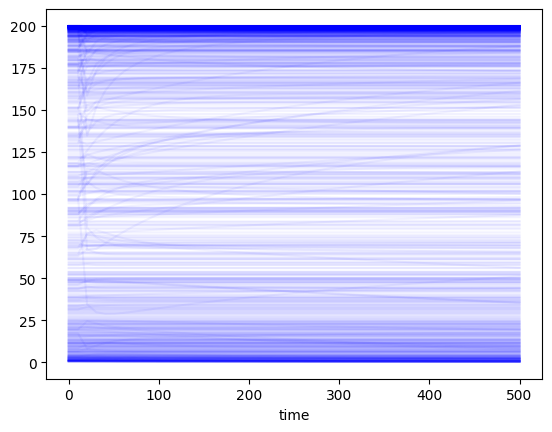

In [24]:
idx_species = -1
plt.plot(np.repeat(ts[None, :], repeats=1000, axis=0).T, ys[:1000, :, idx_species].T, alpha=0.05, color='b')
plt.xlabel('time')

In [109]:
# print(data_writer.top_write_dir)
# data_writer.output(data=analytics, out_type='json', out_name='analytics')
# data_writer.output(data=ys, out_type='npy', out_name='ys')
# data_writer.output(data=ts, out_type='npy', out_name='ts')
# data_writer.output(data=y0m, out_type='npy', out_name='y0m')
# data_writer.output(data=fake_circuits, out_type='npy', out_name='fake_circuits')

./data/tests/2024_12_13_132710


In [25]:
analytics['sensitivity_wrt_species-6'] = np.array(analytics['sensitivity_wrt_species-6'])
analytics['precision_wrt_species-6'] = np.array(analytics['precision_wrt_species-6'])
analytics['overshoot'] = np.array(analytics['overshoot'])

In [192]:
idx_species = -1
idx_max = np.argmax(analytics['overshoot'][:, idx_species])

Array([-24.317032  ,  -0.        , -12.547203  ,  -1.2381325 ,
        -0.19318962,  -0.24349833], dtype=float32)

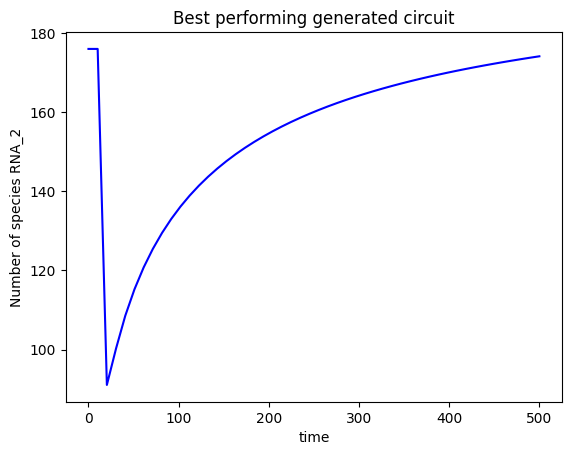

In [196]:
plt.plot(ts, ys[idx_max, :, idx_species].T, color='b')
plt.xlabel('time')
plt.ylabel(f'Number of species {input_species[idx_species]}')
plt.title('Best performing generated circuit')
fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idx_max]

# Visualise

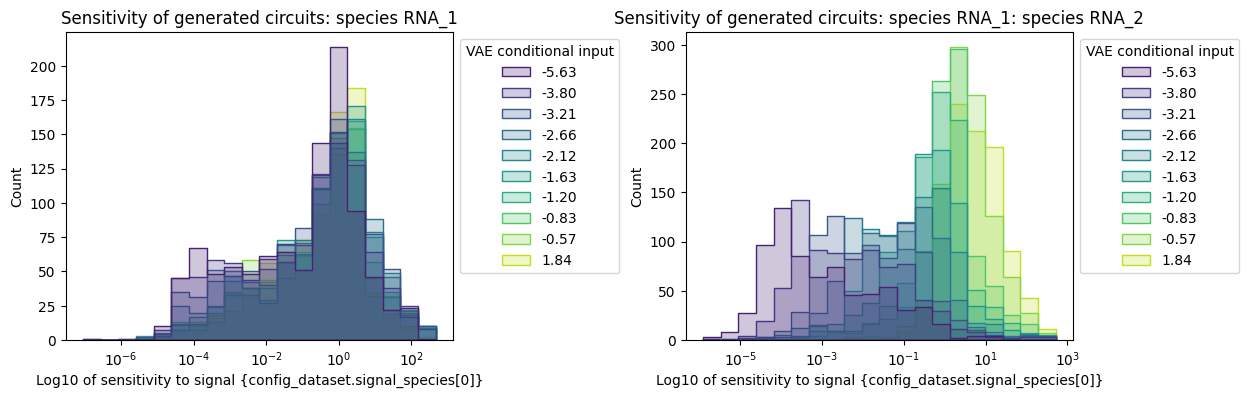

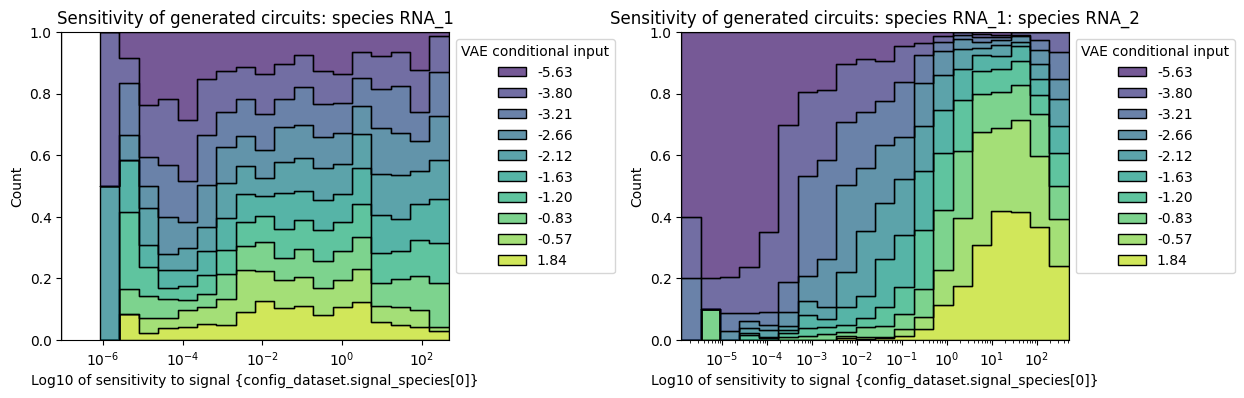

In [119]:
output_species = ['RNA_1', 'RNA_2']

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Sensitivity of generated circuits', x_label='Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['sensitivity_wrt_species-6'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Sensitivity of generated circuits', x_label='Log10 of sensitivity to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)


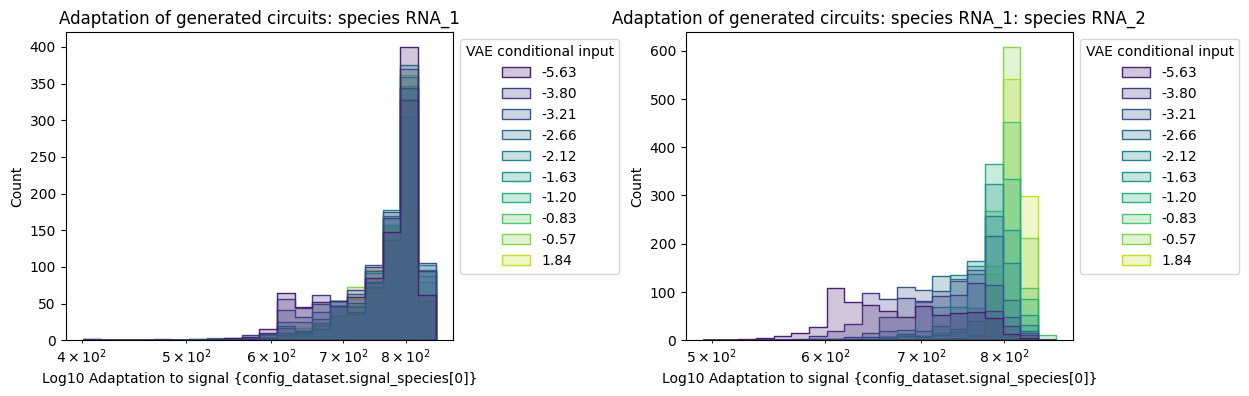

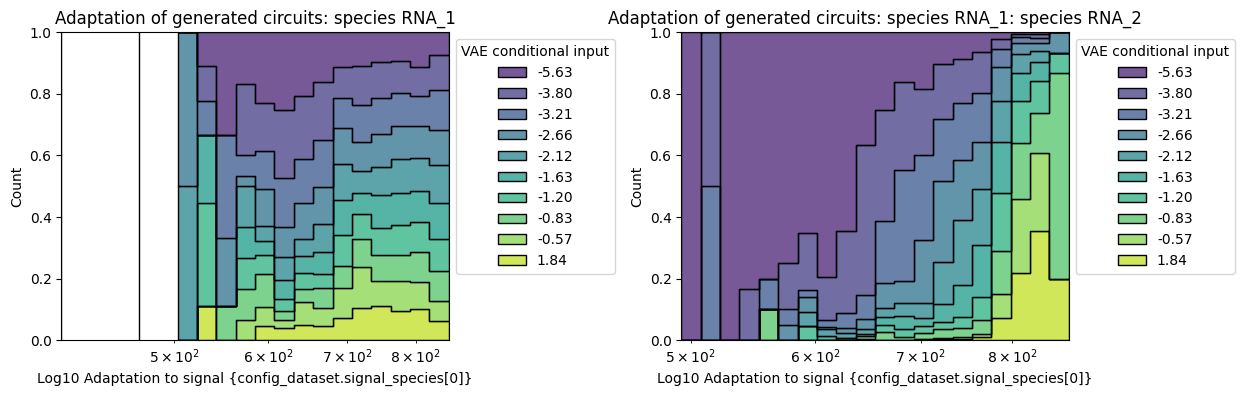

In [120]:
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity_wrt_species-6'], analytics['precision_wrt_species-6'])

vis_sampled_histplot(analytics['adaptation'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Adaptation of generated circuits', x_label='Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='layer', show=True)

vis_sampled_histplot(analytics['adaptation'], y_datanormaliser, model_brn, output_species, # config_dataset.output_species,
                     title=f'Adaptation of generated circuits', x_label='Log10 Adaptation to signal {config_dataset.signal_species[0]}', multiple='fill', show=True)


/tmp/ipykernel_1326156/4270803140.py:18: RuntimeWarning: divide by zero encountered in log10
  diffs_conditional_real_sens = np.log10(jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
/tmp/ipykernel_1326156/4270803140.py:18: RuntimeWarning: divide by zero encountered in log10
  diffs_conditional_real_sens = np.log10(jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted

Diffs: [ 5.106015    3.1995997   2.7476883   2.269594    1.7970183   1.238493
  0.7147919   0.21090972 -0.48937523 -2.5526946 ] 20.32618
Diffs: [ 1.7255461   0.95322824  1.0407481   1.1257892   1.1751703   1.1425741
  1.0331556   0.94190663  1.0926999  -1.1799612 ] 11.41078


Text(0.5, 0.98, 'Difference between VAE output and conditioning\ninput in 50th percentile of sensitivity')

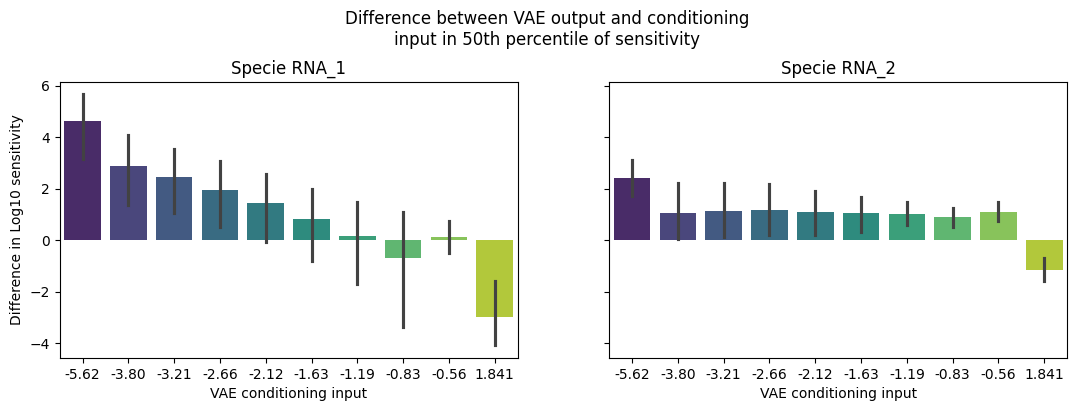

In [128]:
def plot_bar(diffs_conditional_real_sens, sampled_conds, ax, palette='viridis'):
    sns.barplot(pd.DataFrame(diffs_conditional_real_sens.T, columns=[
                str(ii)[:5] for ii in sampled_conds.flatten()]), palette=palette, ax=ax)
    plt.xlabel('VAE conditioning input')
    plt.ylabel('Difference in Log10 sensitivity')


analytics['sensitivity_wrt_species-6'] = np.where(np.isnan(
    analytics['sensitivity_wrt_species-6']), 0, analytics['sensitivity_wrt_species-6'])
n_categories = fake_circuits.shape[0]
sampled_conds = np.array(
    sorted(y_datanormaliser.metadata['category_map'].values()))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13, 4))
fig.subplots_adjust(hspace=0.3, top=0.8)
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    diffs_conditional_real_sens = np.log10(jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        analytics['sensitivity_wrt_species-6'][:, output_idx].reshape(fake_circuits.shape[0], n_to_sample))) - sampled_conds[:, None]

    plt.axes(axs[i])
    plot_bar(diffs_conditional_real_sens, sampled_conds, axs[i])
    plt.title(f'Specie {output_specie}')
    print('Diffs:', diffs_conditional_real_sens[:, 1], np.sum(
        np.abs(diffs_conditional_real_sens[:, 1])))

plt.suptitle(
    'Difference between VAE output and conditioning\ninput in 50th percentile of sensitivity')

/tmp/ipykernel_1326156/3058509897.py:4: RuntimeWarning: divide by zero encountered in log10
  diffs_conditional_real_sens = np.log10(jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


Text(0.5, 1.0, 'Difference between target sensitivity and\n50th percentile of actual sensitivity: Species RNA_2')

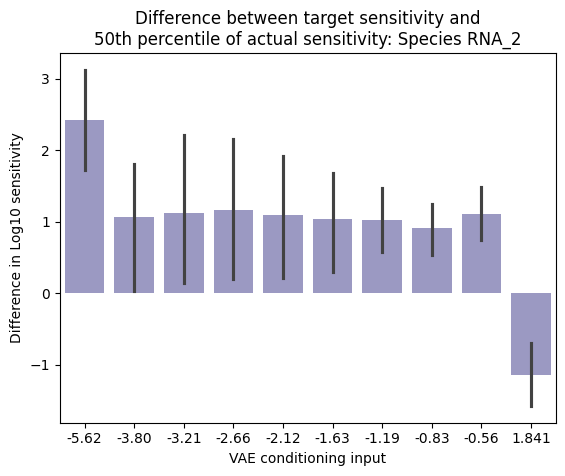

In [189]:
# s = np.where(analytics['sensitivity_wrt_species-6'] > 0, analytics['sensitivity_wrt_species-6'], 1e-5)
s = analytics['sensitivity_wrt_species-6']
output_idx = [s.name for s in model_brn.species].index(config_dataset.output_species[0])
diffs_conditional_real_sens = np.log10(jax.vmap(lambda xxx: jnp.percentile(xxx, q=np.array([25, 50, 75])))(
        s[:, output_idx].reshape(fake_circuits.shape[0], n_to_sample))) - sampled_conds[:, None]
plot_bar(diffs_conditional_real_sens, sampled_conds, plt.subplot(1,1,1), 
         palette=sns.cubehelix_palette(start=3, rot=0, dark=0.6, light=.6, reverse=False, as_cmap=False, n_colors=n_categories))
        #  palette=sns.cubehelix_palette(start=1, rot=1.5, dark=0.3, light=.7, reverse=False, as_cmap=False, n_colors=10))
plt.title(f'Difference between target sensitivity and\n50th percentile of actual sensitivity: Species {config_dataset.output_species[0]}')

category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


Text(0, 0.5, 'Difference in Log10 sensitivity')

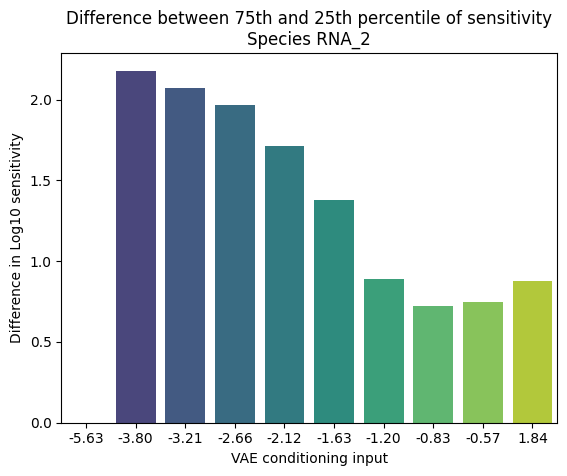

In [199]:
sns.barplot(pd.DataFrame((diffs_conditional_real_sens[..., -1] - diffs_conditional_real_sens[..., 0])[None, :], columns=[
            f'{ii:.2f}' for ii in sampled_conds.flatten()]), palette='viridis')
plt.title(f'Difference between 75th and 25th percentile of sensitivity\nSpecies {config_dataset.output_species[0]}')
plt.xlabel('VAE conditioning input')
plt.ylabel('Difference in Log10 sensitivity')

Text(0.5, 0.98, 'Generated circuits: sensitivity vs. precision')

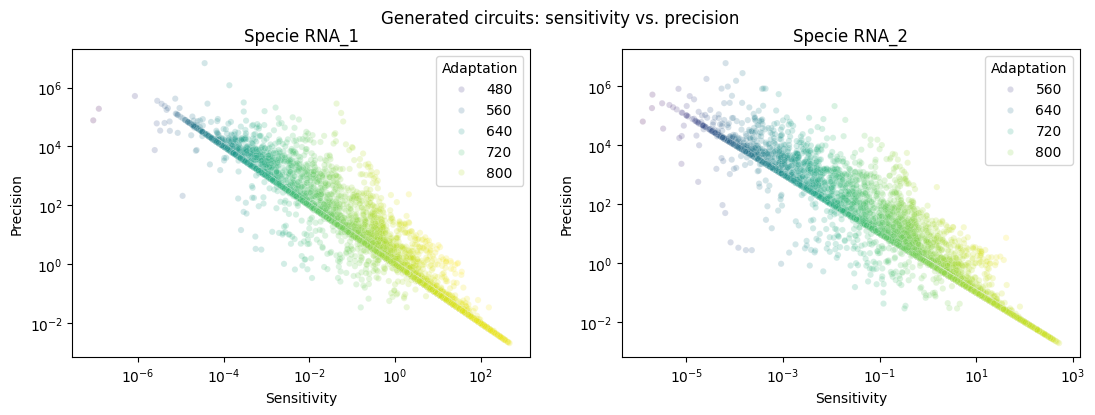

In [117]:
fig = plt.figure(figsize=(13, 4))

category_array = np.array(sorted(y_datanormaliser.metadata["category_map"].values())).repeat(
    len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata["category_map"]))
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['VAE conditioning input'] = category_array
    ax = plt.subplot(1,2,i+1)
    sns.scatterplot(d, x='Sensitivity', y='Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Specie {output_specie}')
plt.suptitle('Generated circuits: sensitivity vs. precision')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

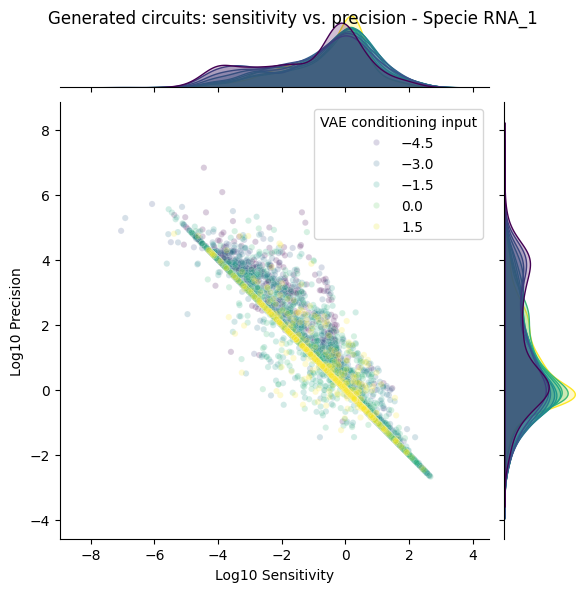

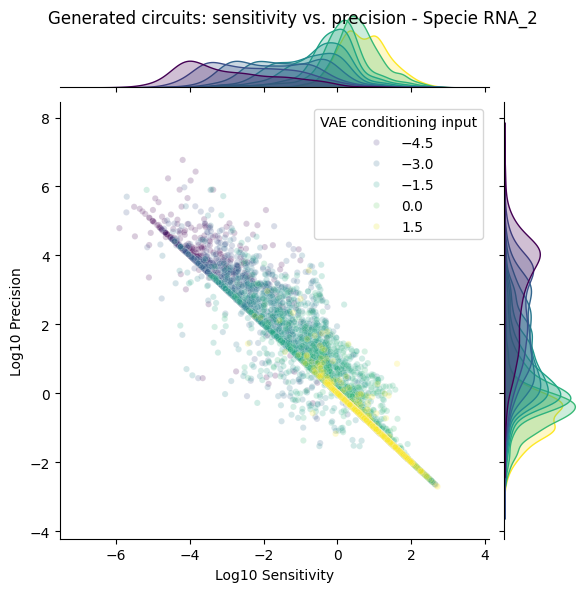

In [118]:
# fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(top=0.8)

category_array = np.array(sorted(y_datanormaliser.metadata["category_map"].values())).repeat(
    len(analytics['sensitivity_wrt_species-6'])//len(y_datanormaliser.metadata["category_map"]))
for i, output_specie in enumerate(output_species):
    output_idx = [s.name for s in model_brn.species].index(output_specie)
    d = pd.DataFrame()
    d['Sensitivity'] = analytics['sensitivity_wrt_species-6'][:, output_idx]
    d['Precision'] = analytics['precision_wrt_species-6'][:, output_idx]
    d['Adaptation'] = analytics['adaptation'][:, output_idx]
    d['Log10 Sensitivity'] = np.log10(d['Sensitivity'])
    d['Log10 Precision'] = np.log10(d['Precision'])
    d['VAE conditioning input'] = category_array
    # ax = plt.subplot(1,2,i+1)
    # sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='Adaptation', palette='viridis', s=20)
    sns.jointplot(d, x='Log10 Sensitivity', y='Log10 Precision', alpha=0.2, hue='VAE conditioning input', palette='viridis', s=20)
    # plt.title(f'Specie {output_specie}')
    plt.suptitle(f'Generated circuits: sensitivity vs. precision - Specie {output_specie}')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))